In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm]"

In [2]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
)
from monai.utils import set_determinism
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tempfile
import shutil
import os
import glob


In [3]:
set_determinism(seed=42)

In [4]:
print_config()

MONAI version: 0.7.dev2131
Numpy version: 1.19.5
Pytorch version: 1.7.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 57467c75bff90e6c9da74461f7da3a828a39626b

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.2.0
Tensorboard version: 2.4.1
gdown version: 3.13.0
TorchVision version: 0.8.1
tqdm version: 4.61.1
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
class ConvertToBinaryChannel(MapTransform):
   

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] > 0)
            d[key] = np.stack(result, axis=0).astype(np.float32)
#             print(d[key].shape)
#             print(d[key].max())
        return d

In [6]:
train_transform = Compose(
    [   
        ConvertToBinaryChannel(keys=["label"]),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
#         Orientationd(keys=["image", "label"], axcodes="RAS"),
#         RandSpatialCropd(
#             keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
#         ),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
#         RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        ConvertToBinaryChannel(keys=["label"]),
#         Spacingd(
#             keys=["image", "label"],
#             pixdim=(1.5, 1.5, 2.0),
#             mode=("bilinear", "nearest"),
#         ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [7]:
data_df=pd.DataFrame({"image":[path for path in sorted(Path("../input/medical-dataset").glob("train*/**/images/*"))],
                    "mask":[path for path in sorted(Path("../input/medical-dataset").glob("train*/**/masks/*"))],
                    "cood":[path for path in sorted(Path("../input/medical-dataset").glob("train*/**/seeds.npy"))]})

In [8]:
data_df2=pd.DataFrame({"image":[path for path in sorted(Path("../input/medical-dataset-1").glob("train*/**/images/*"))],
                    "mask":[path for path in sorted(Path("../input/medical-dataset-1").glob("train*/**/masks/*"))],
                    "cood":[path for path in sorted(Path("../input/medical-dataset-1").glob("train*/**/seeds.npy"))]})

In [9]:
data_df=pd.concat([data_df,data_df2],ignore_index=False)
data_df=data_df.reset_index(drop=True)

In [10]:
len(data_df)

320

In [11]:
val_data_df=pd.DataFrame({"image":[path for path in sorted(Path("../input/medical-dataset").glob("validation*/**/images/*"))],
                    "mask":[path for path in sorted(Path("../input/medical-dataset").glob("validation*/**/masks/*"))],
                    "cood":[path for path in sorted(Path("../input/medical-dataset").glob("validation*/**/seeds.npy"))]})

In [12]:
val_data_df.head()

,image,mask,cood
0,../input/medical-dataset/validation1/009/image...,../input/medical-dataset/validation1/009/masks...,../input/medical-dataset/validation1/009/seeds...
1,../input/medical-dataset/validation1/013/image...,../input/medical-dataset/validation1/013/masks...,../input/medical-dataset/validation1/013/seeds...
2,../input/medical-dataset/validation1/015/image...,../input/medical-dataset/validation1/015/masks...,../input/medical-dataset/validation1/015/seeds...
3,../input/medical-dataset/validation1/017/image...,../input/medical-dataset/validation1/017/masks...,../input/medical-dataset/validation1/017/seeds...
4,../input/medical-dataset/validation1/021/image...,../input/medical-dataset/validation1/021/masks...,../input/medical-dataset/validation1/021/seeds...


In [13]:
class ctscanDataset(Dataset):
    def __init__(self, data_df,transform):
        self.image=data_df["image"]
        self.mask=data_df["mask"]
        self.transform=transform
        
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        try:
            image=np.resize(np.load(self.image[idx])[:,:,:40],(512,512,40)).astype(np.float32)
            mask=np.resize(np.load(self.mask[idx])[:,:,:40],(512,512,40)).astype(np.float32)
            transformed=self.transform({"image":image,
                                        "label":mask})
            image=torch.unsqueeze(transformed["image"],0)
            mask=transformed["label"]
        except:
            return None
        return {
            "image":image,
            "label":mask
        }

In [14]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [15]:
train_dataset=ctscanDataset(data_df, train_transform)
val_dataset=ctscanDataset(val_data_df, val_transform)

In [16]:
train_dataloader=DataLoader(train_dataset,
                            batch_size=8,
                            shuffle=True,
                            num_workers=2,
                           collate_fn=collate_fn)
val_dataloader=DataLoader(val_dataset,
                            batch_size=8,
                            shuffle=True,
                            num_workers=2,
                         collate_fn=collate_fn)

In [17]:
temp=next(iter(val_dataloader))

In [18]:
temp["label"].shape

torch.Size([8, 1, 512, 512, 40])

In [19]:
val_dataset[0]["image"].shape

torch.Size([1, 512, 512, 40])

image shape: torch.Size([8, 1, 512, 512, 40])


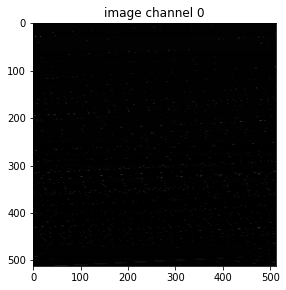

label shape: torch.Size([8, 1, 512, 512, 40])


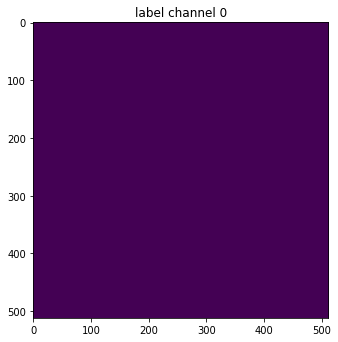

In [20]:
print(f"image shape: {temp['image'].shape}")
plt.figure("image", (20,20))
for i in range(1):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(temp["image"][0,i, :, :, 20].detach().cpu().numpy(), cmap="gray")
plt.show()
print(f"label shape: {temp['label'].shape}")
plt.figure("label", (18, 6))
for i in range(1):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(temp["label"][0,i, :, :, 20].detach().cpu())
plt.show()

In [21]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("../input/unet-3d/unet3dNoBG.pth").to(device)
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-5, weight_decay=1e-6, amsgrad=True
)
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")
post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
)
scaler = torch.cuda.amp.GradScaler()

In [23]:
print(model)

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [24]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_dataloader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_dataloader.batch_size}"
            f", train_loss: {loss.item():.4f}"
        )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in tqdm(val_dataloader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 128, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model,
                    "best_metric_model.pth",
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" Seeds metric: {metric_tc:.4f} "
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9980
2/40, train_loss: 0.9980
3/40, train_loss: 0.9976
4/40, train_loss: 0.9989
5/40, train_loss: 0.9968
6/40, train_loss: 0.9978
7/40, train_loss: 0.9984
8/40, train_loss: 0.9994
9/40, train_loss: 0.9998
10/40, train_loss: 0.9991
11/40, train_loss: 0.9993
12/40, train_loss: 0.9987
13/40, train_loss: 0.9990
14/40, train_loss: 0.9979
15/40, train_loss: 0.9994
16/40, train_loss: 0.9990
17/40, train_loss: 0.9999
18/40, train_loss: 0.9982
19/40, train_loss: 0.9994
20/40, train_loss: 0.9995
21/40, train_loss: 0.9955
22/40, train_loss: 0.9975
23/40, train_loss: 0.9969
24/40, train_loss: 0.9978
25/40, train_loss: 0.9995
26/40, train_loss: 0.9996
27/40, train_loss: 0.9993
28/40, train_loss: 0.9972
29/40, train_loss: 0.9984
30/40, train_loss: 0.9987
31/40, train_loss: 0.9998
32/40, train_loss: 0.9994
33/40, train_loss: 0.9990
34/40, train_loss: 0.9986
35/40, train_loss: 0.9973
36/40, train_loss: 0.9970
37/40, train_loss: 0.9982
38/40, train_loss: 0.9996
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9979
2/40, train_loss: 0.9997
3/40, train_loss: 0.9966
4/40, train_loss: 0.9972
5/40, train_loss: 0.9990
6/40, train_loss: 0.9972
7/40, train_loss: 0.9992
8/40, train_loss: 0.9982
9/40, train_loss: 0.9973
10/40, train_loss: 0.9978
11/40, train_loss: 0.9983
12/40, train_loss: 0.9996
13/40, train_loss: 0.9979
14/40, train_loss: 0.9996
15/40, train_loss: 0.9988
16/40, train_loss: 0.9977
17/40, train_loss: 0.9977
18/40, train_loss: 0.9989
19/40, train_loss: 0.9982
20/40, train_loss: 0.9975
21/40, train_loss: 0.9984
22/40, train_loss: 0.9994
23/40, train_loss: 1.0000
24/40, train_loss: 1.0000
25/40, train_loss: 0.9978
26/40, train_loss: 0.9985
27/40, train_loss: 0.9981
28/40, train_loss: 0.9979
29/40, train_loss: 0.9986
30/40, train_loss: 0.9986
31/40, train_loss: 0.9989
32/40, train_loss: 0.9981
33/40, train_loss: 0.9965
34/40, train_loss: 1.0000
35/40, train_loss: 0.9982
36/40, train_loss: 0.9993
37/40, train_loss: 0.9994
38/40, train_loss: 0.9980
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

saved new best metric model
current epoch: 2 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 2
----------
epoch 3/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9994
2/40, train_loss: 0.9985
3/40, train_loss: 0.9980
4/40, train_loss: 0.9983
5/40, train_loss: 0.9987
6/40, train_loss: 0.9952
7/40, train_loss: 0.9992
8/40, train_loss: 0.9983
9/40, train_loss: 0.9985
10/40, train_loss: 0.9991
11/40, train_loss: 0.9988
12/40, train_loss: 0.9956
13/40, train_loss: 0.9971
14/40, train_loss: 0.9975
15/40, train_loss: 0.9981
16/40, train_loss: 0.9991
17/40, train_loss: 0.9988
18/40, train_loss: 0.9984
19/40, train_loss: 0.9985
20/40, train_loss: 0.9983
21/40, train_loss: 1.0000
22/40, train_loss: 1.0000
23/40, train_loss: 0.9999
24/40, train_loss: 0.9993
25/40, train_loss: 0.9997
26/40, train_loss: 0.9986
27/40, train_loss: 0.9993
28/40, train_loss: 0.9985
29/40, train_loss: 0.9985
30/40, train_loss: 0.9983
31/40, train_loss: 0.9983
32/40, train_loss: 0.9973
33/40, train_loss: 0.9986
34/40, train_loss: 0.9992
35/40, train_loss: 0.9978
36/40, train_loss: 0.9981
37/40, train_loss: 0.9986
38/40, train_loss: 0.9988
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9988
2/40, train_loss: 0.9968
3/40, train_loss: 0.9992
4/40, train_loss: 0.9985
5/40, train_loss: 0.9971
6/40, train_loss: 0.9986
7/40, train_loss: 0.9978
8/40, train_loss: 0.9977
9/40, train_loss: 0.9984
10/40, train_loss: 0.9993
11/40, train_loss: 1.0000
12/40, train_loss: 0.9986
13/40, train_loss: 0.9976
14/40, train_loss: 0.9999
15/40, train_loss: 0.9999
16/40, train_loss: 0.9986
17/40, train_loss: 0.9983
18/40, train_loss: 0.9980
19/40, train_loss: 0.9973
20/40, train_loss: 0.9994
21/40, train_loss: 0.9990
22/40, train_loss: 0.9985
23/40, train_loss: 0.9984
24/40, train_loss: 0.9987
25/40, train_loss: 0.9970
26/40, train_loss: 0.9985
27/40, train_loss: 0.9953
28/40, train_loss: 0.9982
29/40, train_loss: 0.9982
30/40, train_loss: 0.9980
31/40, train_loss: 0.9972
32/40, train_loss: 0.9992
33/40, train_loss: 0.9982
34/40, train_loss: 0.9991
35/40, train_loss: 0.9997
36/40, train_loss: 0.9993
37/40, train_loss: 0.9993
38/40, train_loss: 0.9982
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

saved new best metric model
current epoch: 4 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 4
----------
epoch 5/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9985
2/40, train_loss: 0.9985
3/40, train_loss: 0.9971
4/40, train_loss: 0.9980
5/40, train_loss: 0.9980
6/40, train_loss: 0.9992
7/40, train_loss: 0.9984
8/40, train_loss: 0.9990
9/40, train_loss: 0.9987
10/40, train_loss: 0.9981
11/40, train_loss: 0.9983
12/40, train_loss: 0.9990
13/40, train_loss: 1.0000
14/40, train_loss: 0.9971
15/40, train_loss: 0.9985
16/40, train_loss: 0.9968
17/40, train_loss: 0.9971
18/40, train_loss: 0.9970
19/40, train_loss: 0.9967
20/40, train_loss: 0.9995
21/40, train_loss: 0.9989
22/40, train_loss: 0.9995
23/40, train_loss: 0.9974
24/40, train_loss: 0.9992
25/40, train_loss: 0.9985
26/40, train_loss: 0.9990
27/40, train_loss: 1.0000
28/40, train_loss: 0.9992
29/40, train_loss: 0.9988
30/40, train_loss: 0.9983
31/40, train_loss: 0.9987
32/40, train_loss: 1.0000
33/40, train_loss: 0.9993
34/40, train_loss: 0.9981
35/40, train_loss: 0.9980
36/40, train_loss: 0.9971
37/40, train_loss: 0.9986
38/40, train_loss: 0.9988
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9990
2/40, train_loss: 0.9975
3/40, train_loss: 0.9965
4/40, train_loss: 0.9985
5/40, train_loss: 0.9987
6/40, train_loss: 0.9983
7/40, train_loss: 0.9973
8/40, train_loss: 0.9988
9/40, train_loss: 0.9970
10/40, train_loss: 0.9979
11/40, train_loss: 0.9975
12/40, train_loss: 0.9994
13/40, train_loss: 0.9977
14/40, train_loss: 0.9989
15/40, train_loss: 1.0000
16/40, train_loss: 0.9976
17/40, train_loss: 0.9992
18/40, train_loss: 0.9979
19/40, train_loss: 0.9991
20/40, train_loss: 0.9990
21/40, train_loss: 0.9999
22/40, train_loss: 0.9980
23/40, train_loss: 0.9985
24/40, train_loss: 0.9990
25/40, train_loss: 0.9978
26/40, train_loss: 0.9991
27/40, train_loss: 0.9973
28/40, train_loss: 0.9992
29/40, train_loss: 0.9983
30/40, train_loss: 0.9979
31/40, train_loss: 0.9997
32/40, train_loss: 0.9987
33/40, train_loss: 0.9991
34/40, train_loss: 0.9982
35/40, train_loss: 0.9963
36/40, train_loss: 0.9980
37/40, train_loss: 0.9997
38/40, train_loss: 0.9996
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 6 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 4
----------
epoch 7/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9979
2/40, train_loss: 0.9971
3/40, train_loss: 0.9996
4/40, train_loss: 0.9994
5/40, train_loss: 0.9991
6/40, train_loss: 0.9973
7/40, train_loss: 0.9981
8/40, train_loss: 0.9983
9/40, train_loss: 0.9994
10/40, train_loss: 0.9989
11/40, train_loss: 0.9992
12/40, train_loss: 0.9976
13/40, train_loss: 0.9980
14/40, train_loss: 0.9971
15/40, train_loss: 0.9969
16/40, train_loss: 0.9968
17/40, train_loss: 0.9987
18/40, train_loss: 0.9985
19/40, train_loss: 0.9998
20/40, train_loss: 0.9974
21/40, train_loss: 0.9985
22/40, train_loss: 0.9994
23/40, train_loss: 0.9987
24/40, train_loss: 0.9994
25/40, train_loss: 0.9997
26/40, train_loss: 0.9992
27/40, train_loss: 0.9998
28/40, train_loss: 0.9980
29/40, train_loss: 0.9977
30/40, train_loss: 0.9975
31/40, train_loss: 0.9994
32/40, train_loss: 0.9984
33/40, train_loss: 0.9988
34/40, train_loss: 0.9988
35/40, train_loss: 0.9949
36/40, train_loss: 0.9979
37/40, train_loss: 0.9991
38/40, train_loss: 0.9994
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9992
2/40, train_loss: 0.9984
3/40, train_loss: 0.9991
4/40, train_loss: 0.9964
5/40, train_loss: 0.9979
6/40, train_loss: 0.9981
7/40, train_loss: 0.9992
8/40, train_loss: 0.9964
9/40, train_loss: 0.9985
10/40, train_loss: 0.9994
11/40, train_loss: 0.9981
12/40, train_loss: 0.9991
13/40, train_loss: 0.9997
14/40, train_loss: 0.9989
15/40, train_loss: 0.9975
16/40, train_loss: 0.9965
17/40, train_loss: 0.9991
18/40, train_loss: 0.9991
19/40, train_loss: 0.9977
20/40, train_loss: 0.9989
21/40, train_loss: 0.9992
22/40, train_loss: 0.9982
23/40, train_loss: 0.9998
24/40, train_loss: 0.9972
25/40, train_loss: 0.9987
26/40, train_loss: 0.9989
27/40, train_loss: 0.9976
28/40, train_loss: 0.9977
29/40, train_loss: 0.9982
30/40, train_loss: 0.9980
31/40, train_loss: 0.9983
32/40, train_loss: 0.9984
33/40, train_loss: 1.0000
34/40, train_loss: 0.9983
35/40, train_loss: 0.9999
36/40, train_loss: 0.9983
37/40, train_loss: 0.9980
38/40, train_loss: 0.9992
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 8 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 4
----------
epoch 9/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9992
2/40, train_loss: 0.9977
3/40, train_loss: 0.9994
4/40, train_loss: 0.9987
5/40, train_loss: 0.9996
6/40, train_loss: 0.9970
7/40, train_loss: 0.9982
8/40, train_loss: 0.9989
9/40, train_loss: 0.9994
10/40, train_loss: 0.9979
11/40, train_loss: 0.9991
12/40, train_loss: 0.9998
13/40, train_loss: 0.9984
14/40, train_loss: 0.9970
15/40, train_loss: 0.9963
16/40, train_loss: 0.9991
17/40, train_loss: 0.9987
18/40, train_loss: 0.9963
19/40, train_loss: 1.0000
20/40, train_loss: 0.9971
21/40, train_loss: 0.9985
22/40, train_loss: 0.9999
23/40, train_loss: 0.9992
24/40, train_loss: 0.9977
25/40, train_loss: 0.9977
26/40, train_loss: 0.9989
27/40, train_loss: 0.9985
28/40, train_loss: 0.9990
29/40, train_loss: 0.9955
30/40, train_loss: 0.9970
31/40, train_loss: 0.9977
32/40, train_loss: 0.9982
33/40, train_loss: 0.9998
34/40, train_loss: 0.9985
35/40, train_loss: 0.9989
36/40, train_loss: 0.9990
37/40, train_loss: 0.9988
38/40, train_loss: 0.9987
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9992
2/40, train_loss: 0.9991
3/40, train_loss: 0.9991
4/40, train_loss: 0.9990
5/40, train_loss: 1.0000
6/40, train_loss: 0.9951
7/40, train_loss: 0.9996
8/40, train_loss: 0.9997
9/40, train_loss: 0.9994
10/40, train_loss: 0.9998
11/40, train_loss: 0.9990
12/40, train_loss: 0.9968
13/40, train_loss: 0.9986
14/40, train_loss: 0.9958
15/40, train_loss: 0.9971
16/40, train_loss: 0.9965
17/40, train_loss: 0.9992
18/40, train_loss: 0.9994
19/40, train_loss: 0.9968
20/40, train_loss: 0.9991
21/40, train_loss: 0.9992
22/40, train_loss: 1.0000
23/40, train_loss: 0.9977
24/40, train_loss: 0.9991
25/40, train_loss: 0.9995
26/40, train_loss: 0.9982
27/40, train_loss: 0.9966
28/40, train_loss: 0.9981
29/40, train_loss: 0.9979
30/40, train_loss: 0.9975
31/40, train_loss: 0.9980
32/40, train_loss: 0.9974
33/40, train_loss: 0.9985
34/40, train_loss: 0.9990
35/40, train_loss: 0.9983
36/40, train_loss: 0.9988
37/40, train_loss: 0.9995
38/40, train_loss: 0.9981
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 10 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 4
----------
epoch 11/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9991
2/40, train_loss: 0.9999
3/40, train_loss: 0.9985
4/40, train_loss: 0.9963
5/40, train_loss: 0.9978
6/40, train_loss: 0.9976
7/40, train_loss: 0.9994
8/40, train_loss: 0.9969
9/40, train_loss: 0.9999
10/40, train_loss: 0.9980
11/40, train_loss: 0.9969
12/40, train_loss: 0.9987
13/40, train_loss: 0.9999
14/40, train_loss: 0.9997
15/40, train_loss: 0.9988
16/40, train_loss: 0.9989
17/40, train_loss: 0.9963
18/40, train_loss: 0.9976
19/40, train_loss: 0.9978
20/40, train_loss: 0.9986
21/40, train_loss: 0.9996
22/40, train_loss: 0.9988
23/40, train_loss: 0.9988
24/40, train_loss: 0.9974
25/40, train_loss: 0.9985
26/40, train_loss: 0.9987
27/40, train_loss: 0.9991
28/40, train_loss: 0.9995
29/40, train_loss: 0.9979
30/40, train_loss: 0.9998
31/40, train_loss: 0.9986
32/40, train_loss: 0.9967
33/40, train_loss: 0.9987
34/40, train_loss: 0.9969
35/40, train_loss: 0.9992
36/40, train_loss: 0.9984
37/40, train_loss: 0.9985
38/40, train_loss: 0.9998
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9985
2/40, train_loss: 1.0000
3/40, train_loss: 0.9960
4/40, train_loss: 0.9995
5/40, train_loss: 0.9972
6/40, train_loss: 0.9956
7/40, train_loss: 0.9983
8/40, train_loss: 0.9990
9/40, train_loss: 0.9999
10/40, train_loss: 0.9991
11/40, train_loss: 0.9987
12/40, train_loss: 0.9990
13/40, train_loss: 0.9991
14/40, train_loss: 0.9986
15/40, train_loss: 0.9982
16/40, train_loss: 0.9986
17/40, train_loss: 0.9963
18/40, train_loss: 0.9969
19/40, train_loss: 0.9991
20/40, train_loss: 0.9987
21/40, train_loss: 0.9994
22/40, train_loss: 0.9987
23/40, train_loss: 0.9987
24/40, train_loss: 0.9984
25/40, train_loss: 0.9962
26/40, train_loss: 0.9980
27/40, train_loss: 0.9993
28/40, train_loss: 0.9992
29/40, train_loss: 0.9989
30/40, train_loss: 0.9974
31/40, train_loss: 0.9999
32/40, train_loss: 0.9987
33/40, train_loss: 0.9996
34/40, train_loss: 0.9994
35/40, train_loss: 0.9965
36/40, train_loss: 0.9998
37/40, train_loss: 0.9990
38/40, train_loss: 0.9954
39/40, train_loss: 1.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 12 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 4
----------
epoch 13/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9999
2/40, train_loss: 0.9990
3/40, train_loss: 0.9968
4/40, train_loss: 0.9991
5/40, train_loss: 0.9999
6/40, train_loss: 0.9978
7/40, train_loss: 0.9980
8/40, train_loss: 0.9943
9/40, train_loss: 0.9994
10/40, train_loss: 0.9968
11/40, train_loss: 0.9998
12/40, train_loss: 0.9982
13/40, train_loss: 0.9992
14/40, train_loss: 0.9994
15/40, train_loss: 0.9981
16/40, train_loss: 0.9987
17/40, train_loss: 0.9995
18/40, train_loss: 0.9995
19/40, train_loss: 0.9982
20/40, train_loss: 1.0000
21/40, train_loss: 0.9991
22/40, train_loss: 0.9974
23/40, train_loss: 0.9976
24/40, train_loss: 0.9966
25/40, train_loss: 0.9984
26/40, train_loss: 0.9972
27/40, train_loss: 0.9988
28/40, train_loss: 0.9981
29/40, train_loss: 0.9973
30/40, train_loss: 0.9970
31/40, train_loss: 0.9990
32/40, train_loss: 0.9979
33/40, train_loss: 0.9982
34/40, train_loss: 1.0000
35/40, train_loss: 0.9980
36/40, train_loss: 0.9967
37/40, train_loss: 0.9997
38/40, train_loss: 0.9991
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9989
2/40, train_loss: 0.9986
3/40, train_loss: 0.9985
4/40, train_loss: 0.9993
5/40, train_loss: 0.9982
6/40, train_loss: 0.9963
7/40, train_loss: 0.9985
8/40, train_loss: 0.9983
9/40, train_loss: 0.9996
10/40, train_loss: 0.9971
11/40, train_loss: 0.9977
12/40, train_loss: 0.9985
13/40, train_loss: 1.0000
14/40, train_loss: 0.9990
15/40, train_loss: 0.9967
16/40, train_loss: 0.9984
17/40, train_loss: 0.9978
18/40, train_loss: 0.9994
19/40, train_loss: 0.9975
20/40, train_loss: 0.9986
21/40, train_loss: 0.9979
22/40, train_loss: 0.9981
23/40, train_loss: 0.9991
24/40, train_loss: 0.9984
25/40, train_loss: 0.9996
26/40, train_loss: 0.9998
27/40, train_loss: 0.9993
28/40, train_loss: 0.9959
29/40, train_loss: 0.9992
30/40, train_loss: 0.9978
31/40, train_loss: 0.9990
32/40, train_loss: 0.9987
33/40, train_loss: 0.9998
34/40, train_loss: 0.9953
35/40, train_loss: 0.9975
36/40, train_loss: 0.9980
37/40, train_loss: 0.9990
38/40, train_loss: 0.9998
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 14 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 4
----------
epoch 15/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9994
2/40, train_loss: 0.9988
3/40, train_loss: 0.9990
4/40, train_loss: 0.9978
5/40, train_loss: 0.9988
6/40, train_loss: 0.9991
7/40, train_loss: 0.9980
8/40, train_loss: 0.9989
9/40, train_loss: 0.9991
10/40, train_loss: 0.9983
11/40, train_loss: 0.9983
12/40, train_loss: 0.9979
13/40, train_loss: 0.9974
14/40, train_loss: 0.9986
15/40, train_loss: 0.9988
16/40, train_loss: 0.9972
17/40, train_loss: 0.9991
18/40, train_loss: 0.9989
19/40, train_loss: 0.9956
20/40, train_loss: 0.9987
21/40, train_loss: 0.9992
22/40, train_loss: 0.9984
23/40, train_loss: 0.9985
24/40, train_loss: 1.0000
25/40, train_loss: 1.0000
26/40, train_loss: 0.9986
27/40, train_loss: 0.9996
28/40, train_loss: 0.9981
29/40, train_loss: 0.9987
30/40, train_loss: 0.9987
31/40, train_loss: 0.9990
32/40, train_loss: 0.9983
33/40, train_loss: 0.9974
34/40, train_loss: 0.9974
35/40, train_loss: 0.9974
36/40, train_loss: 0.9972
37/40, train_loss: 0.9981
38/40, train_loss: 0.9993
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9983
2/40, train_loss: 0.9982
3/40, train_loss: 0.9979
4/40, train_loss: 0.9981
5/40, train_loss: 0.9986
6/40, train_loss: 0.9974
7/40, train_loss: 0.9989
8/40, train_loss: 0.9989
9/40, train_loss: 0.9996
10/40, train_loss: 0.9970
11/40, train_loss: 0.9994
12/40, train_loss: 0.9984
13/40, train_loss: 0.9988
14/40, train_loss: 0.9987
15/40, train_loss: 0.9974
16/40, train_loss: 0.9997
17/40, train_loss: 0.9987
18/40, train_loss: 1.0000
19/40, train_loss: 0.9999
20/40, train_loss: 0.9988
21/40, train_loss: 0.9985
22/40, train_loss: 0.9987
23/40, train_loss: 0.9983
24/40, train_loss: 0.9986
25/40, train_loss: 0.9984
26/40, train_loss: 0.9979
27/40, train_loss: 0.9981
28/40, train_loss: 0.9977
29/40, train_loss: 0.9983
30/40, train_loss: 0.9987
31/40, train_loss: 0.9993
32/40, train_loss: 0.9985
33/40, train_loss: 1.0000
34/40, train_loss: 0.9963
35/40, train_loss: 0.9978
36/40, train_loss: 0.9974
37/40, train_loss: 0.9986
38/40, train_loss: 0.9964
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 16 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 4
----------
epoch 17/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9964
2/40, train_loss: 0.9979
3/40, train_loss: 0.9980
4/40, train_loss: 0.9987
5/40, train_loss: 0.9975
6/40, train_loss: 0.9989
7/40, train_loss: 0.9967
8/40, train_loss: 0.9995
9/40, train_loss: 0.9972
10/40, train_loss: 0.9990
11/40, train_loss: 0.9977
12/40, train_loss: 0.9980
13/40, train_loss: 0.9994
14/40, train_loss: 0.9992
15/40, train_loss: 0.9983
16/40, train_loss: 0.9984
17/40, train_loss: 0.9989
18/40, train_loss: 0.9978
19/40, train_loss: 0.9984
20/40, train_loss: 0.9983
21/40, train_loss: 0.9984
22/40, train_loss: 0.9976
23/40, train_loss: 0.9987
24/40, train_loss: 1.0000
25/40, train_loss: 0.9989
26/40, train_loss: 0.9982
27/40, train_loss: 0.9974
28/40, train_loss: 0.9990
29/40, train_loss: 0.9993
30/40, train_loss: 0.9990
31/40, train_loss: 0.9985
32/40, train_loss: 0.9981
33/40, train_loss: 0.9995
34/40, train_loss: 0.9994
35/40, train_loss: 0.9983
36/40, train_loss: 0.9998
37/40, train_loss: 0.9990
38/40, train_loss: 0.9973
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9968
2/40, train_loss: 0.9990
3/40, train_loss: 0.9981
4/40, train_loss: 0.9974
5/40, train_loss: 0.9964
6/40, train_loss: 0.9989
7/40, train_loss: 0.9979
8/40, train_loss: 0.9990
9/40, train_loss: 0.9980
10/40, train_loss: 0.9995
11/40, train_loss: 0.9985
12/40, train_loss: 0.9988
13/40, train_loss: 0.9981
14/40, train_loss: 0.9982
15/40, train_loss: 0.9984
16/40, train_loss: 0.9983
17/40, train_loss: 0.9996
18/40, train_loss: 0.9967
19/40, train_loss: 0.9984
20/40, train_loss: 1.0000
21/40, train_loss: 0.9970
22/40, train_loss: 0.9964
23/40, train_loss: 0.9977
24/40, train_loss: 0.9978
25/40, train_loss: 0.9976
26/40, train_loss: 0.9996
27/40, train_loss: 0.9994
28/40, train_loss: 0.9991
29/40, train_loss: 0.9987
30/40, train_loss: 0.9988
31/40, train_loss: 0.9977
32/40, train_loss: 0.9996
33/40, train_loss: 0.9973
34/40, train_loss: 0.9993
35/40, train_loss: 0.9998
36/40, train_loss: 0.9998
37/40, train_loss: 0.9983
38/40, train_loss: 0.9988
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 18 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 4
----------
epoch 19/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9992
2/40, train_loss: 0.9985
3/40, train_loss: 0.9987
4/40, train_loss: 0.9989
5/40, train_loss: 0.9984
6/40, train_loss: 0.9997
7/40, train_loss: 0.9994
8/40, train_loss: 0.9986
9/40, train_loss: 0.9984
10/40, train_loss: 0.9987
11/40, train_loss: 0.9975
12/40, train_loss: 0.9964
13/40, train_loss: 0.9988
14/40, train_loss: 1.0000
15/40, train_loss: 0.9980
16/40, train_loss: 0.9993
17/40, train_loss: 0.9978
18/40, train_loss: 0.9954
19/40, train_loss: 0.9996
20/40, train_loss: 0.9959
21/40, train_loss: 0.9987
22/40, train_loss: 0.9990
23/40, train_loss: 0.9989
24/40, train_loss: 0.9978
25/40, train_loss: 0.9977
26/40, train_loss: 0.9982
27/40, train_loss: 0.9984
28/40, train_loss: 0.9998
29/40, train_loss: 0.9983
30/40, train_loss: 0.9991
31/40, train_loss: 0.9982
32/40, train_loss: 0.9982
33/40, train_loss: 0.9993
34/40, train_loss: 0.9985
35/40, train_loss: 0.9996
36/40, train_loss: 0.9994
37/40, train_loss: 0.9977
38/40, train_loss: 0.9967
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9994
2/40, train_loss: 0.9998
3/40, train_loss: 0.9980
4/40, train_loss: 0.9983
5/40, train_loss: 1.0000
6/40, train_loss: 0.9989
7/40, train_loss: 0.9985
8/40, train_loss: 0.9989
9/40, train_loss: 0.9991
10/40, train_loss: 0.9970
11/40, train_loss: 0.9967
12/40, train_loss: 0.9983
13/40, train_loss: 0.9956
14/40, train_loss: 0.9984
15/40, train_loss: 0.9989
16/40, train_loss: 0.9993
17/40, train_loss: 0.9989
18/40, train_loss: 0.9996
19/40, train_loss: 0.9995
20/40, train_loss: 0.9997
21/40, train_loss: 0.9975
22/40, train_loss: 0.9977
23/40, train_loss: 0.9992
24/40, train_loss: 0.9986
25/40, train_loss: 0.9993
26/40, train_loss: 0.9965
27/40, train_loss: 0.9994
28/40, train_loss: 0.9998
29/40, train_loss: 0.9980
30/40, train_loss: 0.9986
31/40, train_loss: 0.9981
32/40, train_loss: 0.9973
33/40, train_loss: 0.9971
34/40, train_loss: 0.9983
35/40, train_loss: 0.9982
36/40, train_loss: 0.9975
37/40, train_loss: 0.9958
38/40, train_loss: 0.9991
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

saved new best metric model
current epoch: 20 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 21/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9982
2/40, train_loss: 0.9989
3/40, train_loss: 0.9996
4/40, train_loss: 0.9983
5/40, train_loss: 0.9988
6/40, train_loss: 0.9988
7/40, train_loss: 0.9992
8/40, train_loss: 0.9998
9/40, train_loss: 0.9986
10/40, train_loss: 0.9979
11/40, train_loss: 0.9987
12/40, train_loss: 0.9999
13/40, train_loss: 1.0000
14/40, train_loss: 0.9985
15/40, train_loss: 0.9992
16/40, train_loss: 0.9964
17/40, train_loss: 0.9994
18/40, train_loss: 0.9981
19/40, train_loss: 0.9984
20/40, train_loss: 0.9968
21/40, train_loss: 0.9994
22/40, train_loss: 0.9985
23/40, train_loss: 0.9993
24/40, train_loss: 0.9973
25/40, train_loss: 0.9971
26/40, train_loss: 0.9994
27/40, train_loss: 0.9986
28/40, train_loss: 0.9954
29/40, train_loss: 0.9987
30/40, train_loss: 0.9993
31/40, train_loss: 0.9978
32/40, train_loss: 0.9984
33/40, train_loss: 0.9981
34/40, train_loss: 0.9970
35/40, train_loss: 0.9978
36/40, train_loss: 0.9973
37/40, train_loss: 0.9983
38/40, train_loss: 0.9982
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9953
2/40, train_loss: 0.9976
3/40, train_loss: 0.9996
4/40, train_loss: 0.9989
5/40, train_loss: 0.9990
6/40, train_loss: 0.9996
7/40, train_loss: 0.9987
8/40, train_loss: 0.9978
9/40, train_loss: 0.9998
10/40, train_loss: 0.9975
11/40, train_loss: 0.9992
12/40, train_loss: 0.9993
13/40, train_loss: 0.9992
14/40, train_loss: 0.9994
15/40, train_loss: 0.9981
16/40, train_loss: 0.9999
17/40, train_loss: 0.9976
18/40, train_loss: 0.9991
19/40, train_loss: 0.9987
20/40, train_loss: 0.9982
21/40, train_loss: 0.9981
22/40, train_loss: 0.9989
23/40, train_loss: 0.9985
24/40, train_loss: 0.9952
25/40, train_loss: 0.9970
26/40, train_loss: 0.9985
27/40, train_loss: 0.9991
28/40, train_loss: 0.9989
29/40, train_loss: 0.9994
30/40, train_loss: 0.9997
31/40, train_loss: 0.9978
32/40, train_loss: 0.9982
33/40, train_loss: 0.9986
34/40, train_loss: 0.9994
35/40, train_loss: 0.9986
36/40, train_loss: 0.9977
37/40, train_loss: 0.9978
38/40, train_loss: 0.9959
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 22 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 23/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9998
2/40, train_loss: 0.9986
3/40, train_loss: 0.9989
4/40, train_loss: 0.9992
5/40, train_loss: 0.9975
6/40, train_loss: 0.9993
7/40, train_loss: 0.9978
8/40, train_loss: 0.9987
9/40, train_loss: 0.9994
10/40, train_loss: 0.9993
11/40, train_loss: 0.9992
12/40, train_loss: 0.9991
13/40, train_loss: 0.9994
14/40, train_loss: 0.9976
15/40, train_loss: 0.9993
16/40, train_loss: 0.9985
17/40, train_loss: 0.9968
18/40, train_loss: 0.9984
19/40, train_loss: 0.9970
20/40, train_loss: 0.9999
21/40, train_loss: 0.9996
22/40, train_loss: 0.9990
23/40, train_loss: 0.9997
24/40, train_loss: 0.9976
25/40, train_loss: 0.9987
26/40, train_loss: 0.9980
27/40, train_loss: 0.9987
28/40, train_loss: 0.9998
29/40, train_loss: 0.9969
30/40, train_loss: 0.9983
31/40, train_loss: 0.9970
32/40, train_loss: 0.9980
33/40, train_loss: 0.9966
34/40, train_loss: 0.9994
35/40, train_loss: 0.9980
36/40, train_loss: 0.9956
37/40, train_loss: 0.9990
38/40, train_loss: 0.9960
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9982
2/40, train_loss: 0.9985
3/40, train_loss: 0.9991
4/40, train_loss: 0.9986
5/40, train_loss: 0.9976
6/40, train_loss: 0.9988
7/40, train_loss: 0.9989
8/40, train_loss: 0.9986
9/40, train_loss: 0.9970
10/40, train_loss: 0.9994
11/40, train_loss: 0.9983
12/40, train_loss: 0.9985
13/40, train_loss: 0.9988
14/40, train_loss: 0.9978
15/40, train_loss: 0.9965
16/40, train_loss: 0.9972
17/40, train_loss: 0.9991
18/40, train_loss: 0.9999
19/40, train_loss: 1.0000
20/40, train_loss: 0.9978
21/40, train_loss: 0.9965
22/40, train_loss: 0.9983
23/40, train_loss: 0.9995
24/40, train_loss: 0.9994
25/40, train_loss: 0.9987
26/40, train_loss: 0.9966
27/40, train_loss: 0.9981
28/40, train_loss: 0.9994
29/40, train_loss: 0.9985
30/40, train_loss: 0.9981
31/40, train_loss: 0.9988
32/40, train_loss: 0.9992
33/40, train_loss: 0.9982
34/40, train_loss: 0.9994
35/40, train_loss: 0.9983
36/40, train_loss: 0.9995
37/40, train_loss: 0.9988
38/40, train_loss: 0.9992
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 24 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 25/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9996
2/40, train_loss: 0.9982
3/40, train_loss: 1.0000
4/40, train_loss: 0.9997
5/40, train_loss: 0.9964
6/40, train_loss: 0.9989
7/40, train_loss: 0.9967
8/40, train_loss: 0.9985
9/40, train_loss: 0.9989
10/40, train_loss: 0.9979
11/40, train_loss: 0.9992
12/40, train_loss: 0.9970
13/40, train_loss: 0.9977
14/40, train_loss: 0.9977
15/40, train_loss: 0.9995
16/40, train_loss: 0.9963
17/40, train_loss: 0.9970
18/40, train_loss: 0.9966
19/40, train_loss: 0.9986
20/40, train_loss: 0.9982
21/40, train_loss: 0.9996
22/40, train_loss: 0.9999
23/40, train_loss: 0.9998
24/40, train_loss: 0.9977
25/40, train_loss: 0.9964
26/40, train_loss: 0.9989
27/40, train_loss: 0.9978
28/40, train_loss: 0.9991
29/40, train_loss: 0.9981
30/40, train_loss: 0.9991
31/40, train_loss: 0.9977
32/40, train_loss: 0.9985
33/40, train_loss: 0.9988
34/40, train_loss: 0.9987
35/40, train_loss: 0.9982
36/40, train_loss: 0.9988
37/40, train_loss: 0.9995
38/40, train_loss: 0.9995
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9992
2/40, train_loss: 0.9992
3/40, train_loss: 0.9971
4/40, train_loss: 0.9972
5/40, train_loss: 0.9996
6/40, train_loss: 0.9982
7/40, train_loss: 0.9988
8/40, train_loss: 0.9969
9/40, train_loss: 0.9992
10/40, train_loss: 0.9981
11/40, train_loss: 0.9992
12/40, train_loss: 0.9983
13/40, train_loss: 0.9983
14/40, train_loss: 0.9971
15/40, train_loss: 0.9999
16/40, train_loss: 0.9980
17/40, train_loss: 0.9991
18/40, train_loss: 0.9987
19/40, train_loss: 0.9993
20/40, train_loss: 0.9996
21/40, train_loss: 0.9992
22/40, train_loss: 0.9986
23/40, train_loss: 0.9975
24/40, train_loss: 0.9991
25/40, train_loss: 0.9980
26/40, train_loss: 0.9991
27/40, train_loss: 0.9981
28/40, train_loss: 0.9987
29/40, train_loss: 0.9998
30/40, train_loss: 0.9952
31/40, train_loss: 0.9992
32/40, train_loss: 0.9987
33/40, train_loss: 1.0000
34/40, train_loss: 0.9972
35/40, train_loss: 0.9975
36/40, train_loss: 0.9963
37/40, train_loss: 0.9967
38/40, train_loss: 0.9991
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 26 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 27/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9975
2/40, train_loss: 0.9984
3/40, train_loss: 0.9992
4/40, train_loss: 0.9991
5/40, train_loss: 0.9959
6/40, train_loss: 0.9984
7/40, train_loss: 0.9989
8/40, train_loss: 0.9990
9/40, train_loss: 0.9982
10/40, train_loss: 0.9998
11/40, train_loss: 0.9987
12/40, train_loss: 0.9991
13/40, train_loss: 0.9991
14/40, train_loss: 0.9994
15/40, train_loss: 0.9957
16/40, train_loss: 0.9971
17/40, train_loss: 0.9973
18/40, train_loss: 0.9976
19/40, train_loss: 0.9967
20/40, train_loss: 0.9965
21/40, train_loss: 0.9991
22/40, train_loss: 0.9983
23/40, train_loss: 0.9996
24/40, train_loss: 0.9998
25/40, train_loss: 0.9987
26/40, train_loss: 0.9979
27/40, train_loss: 0.9986
28/40, train_loss: 1.0000
29/40, train_loss: 0.9981
30/40, train_loss: 0.9972
31/40, train_loss: 0.9993
32/40, train_loss: 0.9975
33/40, train_loss: 0.9985
34/40, train_loss: 0.9991
35/40, train_loss: 0.9981
36/40, train_loss: 0.9995
37/40, train_loss: 0.9995
38/40, train_loss: 0.9965
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9996
2/40, train_loss: 0.9989
3/40, train_loss: 0.9985
4/40, train_loss: 0.9993
5/40, train_loss: 0.9987
6/40, train_loss: 0.9981
7/40, train_loss: 0.9991
8/40, train_loss: 0.9992
9/40, train_loss: 0.9993
10/40, train_loss: 0.9979
11/40, train_loss: 0.9984
12/40, train_loss: 0.9974
13/40, train_loss: 1.0000
14/40, train_loss: 1.0000
15/40, train_loss: 0.9980
16/40, train_loss: 0.9983
17/40, train_loss: 0.9979
18/40, train_loss: 0.9990
19/40, train_loss: 0.9965
20/40, train_loss: 0.9984
21/40, train_loss: 0.9994
22/40, train_loss: 0.9982
23/40, train_loss: 0.9980
24/40, train_loss: 0.9987
25/40, train_loss: 0.9985
26/40, train_loss: 0.9999
27/40, train_loss: 0.9990
28/40, train_loss: 0.9991
29/40, train_loss: 0.9963
30/40, train_loss: 0.9973
31/40, train_loss: 0.9983
32/40, train_loss: 0.9970
33/40, train_loss: 0.9987
34/40, train_loss: 0.9970
35/40, train_loss: 0.9993
36/40, train_loss: 0.9961
37/40, train_loss: 0.9987
38/40, train_loss: 0.9981
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 28 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 29/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9985
2/40, train_loss: 0.9994
3/40, train_loss: 0.9994
4/40, train_loss: 0.9984
5/40, train_loss: 0.9973
6/40, train_loss: 0.9977
7/40, train_loss: 0.9992
8/40, train_loss: 0.9981
9/40, train_loss: 0.9976
10/40, train_loss: 1.0000
11/40, train_loss: 0.9973
12/40, train_loss: 0.9974
13/40, train_loss: 0.9995
14/40, train_loss: 0.9979
15/40, train_loss: 0.9976
16/40, train_loss: 0.9992
17/40, train_loss: 0.9980
18/40, train_loss: 0.9973
19/40, train_loss: 0.9992
20/40, train_loss: 0.9968
21/40, train_loss: 0.9989
22/40, train_loss: 0.9985
23/40, train_loss: 0.9991
24/40, train_loss: 0.9973
25/40, train_loss: 0.9974
26/40, train_loss: 0.9989
27/40, train_loss: 0.9986
28/40, train_loss: 0.9986
29/40, train_loss: 0.9984
30/40, train_loss: 0.9980
31/40, train_loss: 0.9976
32/40, train_loss: 0.9994
33/40, train_loss: 0.9976
34/40, train_loss: 0.9984
35/40, train_loss: 1.0000
36/40, train_loss: 0.9985
37/40, train_loss: 0.9973
38/40, train_loss: 0.9992
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9978
2/40, train_loss: 0.9992
3/40, train_loss: 1.0000
4/40, train_loss: 0.9996
5/40, train_loss: 0.9993
6/40, train_loss: 0.9939
7/40, train_loss: 0.9979
8/40, train_loss: 0.9976
9/40, train_loss: 0.9968
10/40, train_loss: 0.9982
11/40, train_loss: 0.9992
12/40, train_loss: 0.9988
13/40, train_loss: 0.9993
14/40, train_loss: 0.9983
15/40, train_loss: 0.9980
16/40, train_loss: 0.9993
17/40, train_loss: 0.9997
18/40, train_loss: 0.9986
19/40, train_loss: 1.0000
20/40, train_loss: 0.9980
21/40, train_loss: 0.9972
22/40, train_loss: 0.9981
23/40, train_loss: 0.9971
24/40, train_loss: 0.9976
25/40, train_loss: 0.9999
26/40, train_loss: 0.9990
27/40, train_loss: 0.9978
28/40, train_loss: 0.9953
29/40, train_loss: 0.9994
30/40, train_loss: 0.9997
31/40, train_loss: 0.9994
32/40, train_loss: 0.9963
33/40, train_loss: 1.0000
34/40, train_loss: 0.9978
35/40, train_loss: 0.9981
36/40, train_loss: 0.9976
37/40, train_loss: 1.0000
38/40, train_loss: 0.9991
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 30 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 31/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9980
2/40, train_loss: 0.9985
3/40, train_loss: 0.9989
4/40, train_loss: 0.9978
5/40, train_loss: 0.9979
6/40, train_loss: 0.9980
7/40, train_loss: 0.9977
8/40, train_loss: 0.9999
9/40, train_loss: 0.9995
10/40, train_loss: 0.9983
11/40, train_loss: 0.9983
12/40, train_loss: 0.9983
13/40, train_loss: 0.9981
14/40, train_loss: 0.9983
15/40, train_loss: 0.9969
16/40, train_loss: 1.0000
17/40, train_loss: 0.9987
18/40, train_loss: 0.9973
19/40, train_loss: 0.9996
20/40, train_loss: 0.9977
21/40, train_loss: 0.9983
22/40, train_loss: 0.9996
23/40, train_loss: 0.9996
24/40, train_loss: 0.9971
25/40, train_loss: 0.9973
26/40, train_loss: 0.9975
27/40, train_loss: 0.9983
28/40, train_loss: 0.9996
29/40, train_loss: 1.0000
30/40, train_loss: 0.9979
31/40, train_loss: 0.9968
32/40, train_loss: 0.9979
33/40, train_loss: 0.9979
34/40, train_loss: 0.9992
35/40, train_loss: 1.0000
36/40, train_loss: 0.9985
37/40, train_loss: 0.9974
38/40, train_loss: 0.9991
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9990
2/40, train_loss: 0.9974
3/40, train_loss: 0.9979
4/40, train_loss: 0.9976
5/40, train_loss: 0.9989
6/40, train_loss: 0.9966
7/40, train_loss: 0.9995
8/40, train_loss: 0.9970
9/40, train_loss: 0.9987
10/40, train_loss: 0.9987
11/40, train_loss: 1.0000
12/40, train_loss: 0.9992
13/40, train_loss: 0.9986
14/40, train_loss: 0.9993
15/40, train_loss: 0.9987
16/40, train_loss: 0.9995
17/40, train_loss: 0.9961
18/40, train_loss: 0.9988
19/40, train_loss: 0.9988
20/40, train_loss: 0.9994
21/40, train_loss: 0.9996
22/40, train_loss: 0.9993
23/40, train_loss: 0.9986
24/40, train_loss: 0.9983
25/40, train_loss: 0.9973
26/40, train_loss: 0.9983
27/40, train_loss: 0.9984
28/40, train_loss: 0.9982
29/40, train_loss: 0.9983
30/40, train_loss: 0.9976
31/40, train_loss: 0.9980
32/40, train_loss: 0.9970
33/40, train_loss: 0.9988
34/40, train_loss: 0.9977
35/40, train_loss: 0.9977
36/40, train_loss: 0.9988
37/40, train_loss: 0.9990
38/40, train_loss: 0.9966
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 32 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 33/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9973
2/40, train_loss: 0.9985
3/40, train_loss: 0.9995
4/40, train_loss: 0.9966
5/40, train_loss: 0.9991
6/40, train_loss: 0.9988
7/40, train_loss: 0.9966
8/40, train_loss: 0.9981
9/40, train_loss: 0.9966
10/40, train_loss: 0.9983
11/40, train_loss: 0.9996
12/40, train_loss: 0.9986
13/40, train_loss: 0.9975
14/40, train_loss: 0.9983
15/40, train_loss: 0.9974
16/40, train_loss: 0.9963
17/40, train_loss: 0.9988
18/40, train_loss: 0.9986
19/40, train_loss: 0.9990
20/40, train_loss: 0.9991
21/40, train_loss: 0.9992
22/40, train_loss: 0.9983
23/40, train_loss: 0.9984
24/40, train_loss: 0.9979
25/40, train_loss: 0.9996
26/40, train_loss: 0.9999
27/40, train_loss: 0.9971
28/40, train_loss: 0.9991
29/40, train_loss: 0.9977
30/40, train_loss: 0.9985
31/40, train_loss: 0.9987
32/40, train_loss: 0.9988
33/40, train_loss: 0.9986
34/40, train_loss: 0.9989
35/40, train_loss: 0.9987
36/40, train_loss: 0.9966
37/40, train_loss: 0.9996
38/40, train_loss: 0.9995
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9992
2/40, train_loss: 0.9967
3/40, train_loss: 0.9986
4/40, train_loss: 0.9998
5/40, train_loss: 0.9966
6/40, train_loss: 0.9977
7/40, train_loss: 0.9984
8/40, train_loss: 0.9991
9/40, train_loss: 0.9978
10/40, train_loss: 0.9987
11/40, train_loss: 0.9975
12/40, train_loss: 0.9991
13/40, train_loss: 0.9985
14/40, train_loss: 0.9985
15/40, train_loss: 0.9995
16/40, train_loss: 0.9994
17/40, train_loss: 0.9985
18/40, train_loss: 0.9986
19/40, train_loss: 0.9976
20/40, train_loss: 0.9983
21/40, train_loss: 0.9979
22/40, train_loss: 0.9986
23/40, train_loss: 0.9990
24/40, train_loss: 0.9985
25/40, train_loss: 0.9999
26/40, train_loss: 0.9974
27/40, train_loss: 0.9979
28/40, train_loss: 0.9983
29/40, train_loss: 1.0000
30/40, train_loss: 0.9958
31/40, train_loss: 0.9991
32/40, train_loss: 0.9981
33/40, train_loss: 0.9989
34/40, train_loss: 0.9979
35/40, train_loss: 0.9992
36/40, train_loss: 0.9991
37/40, train_loss: 0.9964
38/40, train_loss: 0.9993
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 34 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 35/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9982
2/40, train_loss: 0.9988
3/40, train_loss: 0.9994
4/40, train_loss: 0.9992
5/40, train_loss: 0.9972
6/40, train_loss: 0.9981
7/40, train_loss: 0.9947
8/40, train_loss: 0.9983
9/40, train_loss: 0.9987
10/40, train_loss: 0.9997
11/40, train_loss: 0.9998
12/40, train_loss: 0.9965
13/40, train_loss: 1.0000
14/40, train_loss: 0.9969
15/40, train_loss: 0.9970
16/40, train_loss: 0.9985
17/40, train_loss: 0.9992
18/40, train_loss: 0.9984
19/40, train_loss: 0.9988
20/40, train_loss: 0.9958
21/40, train_loss: 0.9969
22/40, train_loss: 0.9983
23/40, train_loss: 0.9976
24/40, train_loss: 0.9978
25/40, train_loss: 0.9972
26/40, train_loss: 0.9997
27/40, train_loss: 0.9989
28/40, train_loss: 0.9973
29/40, train_loss: 0.9998
30/40, train_loss: 1.0000
31/40, train_loss: 0.9982
32/40, train_loss: 0.9993
33/40, train_loss: 0.9989
34/40, train_loss: 0.9991
35/40, train_loss: 0.9989
36/40, train_loss: 0.9989
37/40, train_loss: 0.9973
38/40, train_loss: 0.9994
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9970
2/40, train_loss: 0.9965
3/40, train_loss: 0.9987
4/40, train_loss: 0.9962
5/40, train_loss: 0.9984
6/40, train_loss: 0.9990
7/40, train_loss: 0.9977
8/40, train_loss: 0.9989
9/40, train_loss: 0.9976
10/40, train_loss: 0.9999
11/40, train_loss: 0.9989
12/40, train_loss: 0.9965
13/40, train_loss: 0.9981
14/40, train_loss: 0.9970
15/40, train_loss: 0.9988
16/40, train_loss: 0.9993
17/40, train_loss: 0.9997
18/40, train_loss: 0.9979
19/40, train_loss: 0.9979
20/40, train_loss: 0.9990
21/40, train_loss: 0.9989
22/40, train_loss: 1.0000
23/40, train_loss: 0.9979
24/40, train_loss: 0.9997
25/40, train_loss: 0.9966
26/40, train_loss: 0.9975
27/40, train_loss: 0.9971
28/40, train_loss: 0.9995
29/40, train_loss: 0.9990
30/40, train_loss: 1.0000
31/40, train_loss: 0.9986
32/40, train_loss: 0.9981
33/40, train_loss: 0.9988
34/40, train_loss: 0.9983
35/40, train_loss: 0.9997
36/40, train_loss: 0.9993
37/40, train_loss: 0.9973
38/40, train_loss: 0.9966
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 36 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 37/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9999
2/40, train_loss: 0.9973
3/40, train_loss: 0.9989
4/40, train_loss: 0.9979
5/40, train_loss: 0.9986
6/40, train_loss: 0.9980
7/40, train_loss: 0.9988
8/40, train_loss: 0.9996
9/40, train_loss: 0.9988
10/40, train_loss: 0.9994
11/40, train_loss: 0.9996
12/40, train_loss: 0.9963
13/40, train_loss: 0.9971
14/40, train_loss: 0.9997
15/40, train_loss: 0.9977
16/40, train_loss: 0.9993
17/40, train_loss: 0.9992
18/40, train_loss: 0.9980
19/40, train_loss: 0.9984
20/40, train_loss: 0.9985
21/40, train_loss: 0.9980
22/40, train_loss: 0.9974
23/40, train_loss: 0.9983
24/40, train_loss: 0.9988
25/40, train_loss: 0.9973
26/40, train_loss: 0.9966
27/40, train_loss: 0.9983
28/40, train_loss: 0.9981
29/40, train_loss: 0.9988
30/40, train_loss: 0.9972
31/40, train_loss: 0.9972
32/40, train_loss: 0.9983
33/40, train_loss: 0.9978
34/40, train_loss: 0.9999
35/40, train_loss: 0.9993
36/40, train_loss: 0.9987
37/40, train_loss: 0.9975
38/40, train_loss: 0.9987
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9985
2/40, train_loss: 0.9981
3/40, train_loss: 0.9990
4/40, train_loss: 0.9997
5/40, train_loss: 0.9988
6/40, train_loss: 0.9966
7/40, train_loss: 1.0000
8/40, train_loss: 0.9966
9/40, train_loss: 0.9995
10/40, train_loss: 0.9977
11/40, train_loss: 0.9989
12/40, train_loss: 0.9985
13/40, train_loss: 0.9990
14/40, train_loss: 0.9986
15/40, train_loss: 0.9989
16/40, train_loss: 0.9980
17/40, train_loss: 0.9979
18/40, train_loss: 0.9998
19/40, train_loss: 0.9962
20/40, train_loss: 0.9986
21/40, train_loss: 0.9976
22/40, train_loss: 0.9981
23/40, train_loss: 0.9994
24/40, train_loss: 0.9976
25/40, train_loss: 0.9994
26/40, train_loss: 0.9979
27/40, train_loss: 0.9992
28/40, train_loss: 0.9981
29/40, train_loss: 0.9987
30/40, train_loss: 0.9989
31/40, train_loss: 0.9959
32/40, train_loss: 0.9977
33/40, train_loss: 0.9994
34/40, train_loss: 0.9990
35/40, train_loss: 0.9981
36/40, train_loss: 1.0000
37/40, train_loss: 0.9955
38/40, train_loss: 0.9981
39/40, train_loss: 1.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 38 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 39/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9967
2/40, train_loss: 0.9986
3/40, train_loss: 0.9979
4/40, train_loss: 0.9979
5/40, train_loss: 0.9991
6/40, train_loss: 0.9979
7/40, train_loss: 0.9988
8/40, train_loss: 0.9978
9/40, train_loss: 0.9991
10/40, train_loss: 0.9990
11/40, train_loss: 0.9975
12/40, train_loss: 0.9994
13/40, train_loss: 0.9973
14/40, train_loss: 0.9995
15/40, train_loss: 0.9988
16/40, train_loss: 0.9976
17/40, train_loss: 0.9984
18/40, train_loss: 0.9979
19/40, train_loss: 0.9991
20/40, train_loss: 0.9990
21/40, train_loss: 0.9985
22/40, train_loss: 0.9964
23/40, train_loss: 0.9983
24/40, train_loss: 0.9976
25/40, train_loss: 0.9971
26/40, train_loss: 0.9998
27/40, train_loss: 0.9994
28/40, train_loss: 0.9976
29/40, train_loss: 0.9974
30/40, train_loss: 0.9992
31/40, train_loss: 0.9990
32/40, train_loss: 0.9981
33/40, train_loss: 0.9978
34/40, train_loss: 0.9994
35/40, train_loss: 0.9985
36/40, train_loss: 0.9999
37/40, train_loss: 0.9962
38/40, train_loss: 0.9997
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9941
2/40, train_loss: 0.9994
3/40, train_loss: 0.9987
4/40, train_loss: 0.9975
5/40, train_loss: 0.9972
6/40, train_loss: 0.9984
7/40, train_loss: 0.9970
8/40, train_loss: 0.9994
9/40, train_loss: 0.9962
10/40, train_loss: 0.9993
11/40, train_loss: 0.9969
12/40, train_loss: 0.9997
13/40, train_loss: 0.9957
14/40, train_loss: 0.9982
15/40, train_loss: 0.9993
16/40, train_loss: 0.9998
17/40, train_loss: 0.9979
18/40, train_loss: 0.9992
19/40, train_loss: 1.0000
20/40, train_loss: 0.9972
21/40, train_loss: 0.9995
22/40, train_loss: 0.9972
23/40, train_loss: 0.9998
24/40, train_loss: 0.9999
25/40, train_loss: 0.9985
26/40, train_loss: 0.9989
27/40, train_loss: 0.9983
28/40, train_loss: 0.9982
29/40, train_loss: 0.9977
30/40, train_loss: 0.9962
31/40, train_loss: 0.9984
32/40, train_loss: 0.9994
33/40, train_loss: 0.9994
34/40, train_loss: 0.9986
35/40, train_loss: 0.9994
36/40, train_loss: 0.9993
37/40, train_loss: 0.9998
38/40, train_loss: 0.9969
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 40 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 41/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9984
2/40, train_loss: 0.9963
3/40, train_loss: 0.9991
4/40, train_loss: 0.9982
5/40, train_loss: 0.9992
6/40, train_loss: 0.9984
7/40, train_loss: 0.9981
8/40, train_loss: 0.9988
9/40, train_loss: 0.9999
10/40, train_loss: 0.9981
11/40, train_loss: 0.9989
12/40, train_loss: 0.9976
13/40, train_loss: 0.9994
14/40, train_loss: 0.9969
15/40, train_loss: 0.9992
16/40, train_loss: 0.9977
17/40, train_loss: 0.9982
18/40, train_loss: 0.9994
19/40, train_loss: 0.9983
20/40, train_loss: 0.9982
21/40, train_loss: 0.9963
22/40, train_loss: 0.9985
23/40, train_loss: 0.9979
24/40, train_loss: 0.9987
25/40, train_loss: 0.9983
26/40, train_loss: 0.9980
27/40, train_loss: 0.9979
28/40, train_loss: 0.9992
29/40, train_loss: 0.9981
30/40, train_loss: 0.9989
31/40, train_loss: 0.9969
32/40, train_loss: 0.9994
33/40, train_loss: 0.9994
34/40, train_loss: 0.9990
35/40, train_loss: 0.9977
36/40, train_loss: 0.9982
37/40, train_loss: 0.9986
38/40, train_loss: 0.9978
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9978
2/40, train_loss: 0.9983
3/40, train_loss: 0.9979
4/40, train_loss: 0.9972
5/40, train_loss: 0.9981
6/40, train_loss: 0.9987
7/40, train_loss: 0.9994
8/40, train_loss: 0.9988
9/40, train_loss: 0.9972
10/40, train_loss: 0.9996
11/40, train_loss: 0.9973
12/40, train_loss: 0.9999
13/40, train_loss: 0.9984
14/40, train_loss: 0.9988
15/40, train_loss: 0.9982
16/40, train_loss: 0.9982
17/40, train_loss: 0.9955
18/40, train_loss: 0.9983
19/40, train_loss: 0.9979
20/40, train_loss: 0.9984
21/40, train_loss: 0.9987
22/40, train_loss: 0.9982
23/40, train_loss: 0.9979
24/40, train_loss: 0.9985
25/40, train_loss: 1.0000
26/40, train_loss: 0.9974
27/40, train_loss: 0.9998
28/40, train_loss: 0.9976
29/40, train_loss: 0.9958
30/40, train_loss: 0.9998
31/40, train_loss: 0.9983
32/40, train_loss: 0.9981
33/40, train_loss: 0.9974
34/40, train_loss: 0.9980
35/40, train_loss: 0.9989
36/40, train_loss: 0.9996
37/40, train_loss: 0.9985
38/40, train_loss: 0.9995
39/40, train_loss: 1.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 42 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 43/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9994
2/40, train_loss: 0.9968
3/40, train_loss: 0.9978
4/40, train_loss: 0.9990
5/40, train_loss: 0.9973
6/40, train_loss: 0.9960
7/40, train_loss: 0.9984
8/40, train_loss: 0.9993
9/40, train_loss: 0.9997
10/40, train_loss: 0.9976
11/40, train_loss: 0.9986
12/40, train_loss: 0.9964
13/40, train_loss: 0.9993
14/40, train_loss: 0.9960
15/40, train_loss: 0.9978
16/40, train_loss: 0.9979
17/40, train_loss: 0.9995
18/40, train_loss: 0.9980
19/40, train_loss: 0.9990
20/40, train_loss: 0.9993
21/40, train_loss: 0.9993
22/40, train_loss: 0.9990
23/40, train_loss: 0.9974
24/40, train_loss: 0.9993
25/40, train_loss: 0.9998
26/40, train_loss: 0.9995
27/40, train_loss: 0.9982
28/40, train_loss: 0.9979
29/40, train_loss: 0.9988
30/40, train_loss: 0.9997
31/40, train_loss: 0.9996
32/40, train_loss: 0.9977
33/40, train_loss: 0.9988
34/40, train_loss: 0.9986
35/40, train_loss: 0.9989
36/40, train_loss: 0.9981
37/40, train_loss: 0.9980
38/40, train_loss: 0.9976
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9977
2/40, train_loss: 0.9991
3/40, train_loss: 0.9995
4/40, train_loss: 0.9991
5/40, train_loss: 0.9958
6/40, train_loss: 0.9980
7/40, train_loss: 0.9984
8/40, train_loss: 0.9994
9/40, train_loss: 0.9991
10/40, train_loss: 0.9991
11/40, train_loss: 0.9964
12/40, train_loss: 0.9985
13/40, train_loss: 0.9984
14/40, train_loss: 0.9993
15/40, train_loss: 0.9983
16/40, train_loss: 0.9998
17/40, train_loss: 0.9982
18/40, train_loss: 0.9987
19/40, train_loss: 0.9996
20/40, train_loss: 0.9971
21/40, train_loss: 0.9968
22/40, train_loss: 0.9983
23/40, train_loss: 0.9986
24/40, train_loss: 0.9985
25/40, train_loss: 0.9967
26/40, train_loss: 0.9980
27/40, train_loss: 0.9976
28/40, train_loss: 0.9966
29/40, train_loss: 0.9972
30/40, train_loss: 1.0000
31/40, train_loss: 0.9996
32/40, train_loss: 0.9984
33/40, train_loss: 0.9975
34/40, train_loss: 0.9993
35/40, train_loss: 0.9966
36/40, train_loss: 0.9985
37/40, train_loss: 0.9982
38/40, train_loss: 0.9998
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 44 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 45/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9979
2/40, train_loss: 0.9985
3/40, train_loss: 0.9964
4/40, train_loss: 0.9970
5/40, train_loss: 0.9999
6/40, train_loss: 0.9981
7/40, train_loss: 0.9984
8/40, train_loss: 0.9986
9/40, train_loss: 0.9989
10/40, train_loss: 0.9993
11/40, train_loss: 0.9984
12/40, train_loss: 0.9991
13/40, train_loss: 0.9995
14/40, train_loss: 0.9985
15/40, train_loss: 1.0000
16/40, train_loss: 0.9973
17/40, train_loss: 0.9972
18/40, train_loss: 0.9985
19/40, train_loss: 0.9989
20/40, train_loss: 0.9999
21/40, train_loss: 0.9974
22/40, train_loss: 0.9963
23/40, train_loss: 0.9988
24/40, train_loss: 0.9984
25/40, train_loss: 0.9997
26/40, train_loss: 0.9983
27/40, train_loss: 0.9987
28/40, train_loss: 0.9996
29/40, train_loss: 0.9954
30/40, train_loss: 0.9995
31/40, train_loss: 0.9989
32/40, train_loss: 0.9985
33/40, train_loss: 0.9987
34/40, train_loss: 0.9986
35/40, train_loss: 0.9970
36/40, train_loss: 0.9981
37/40, train_loss: 0.9986
38/40, train_loss: 0.9968
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9975
2/40, train_loss: 0.9993
3/40, train_loss: 0.9964
4/40, train_loss: 0.9993
5/40, train_loss: 0.9975
6/40, train_loss: 0.9980
7/40, train_loss: 0.9970
8/40, train_loss: 0.9984
9/40, train_loss: 0.9985
10/40, train_loss: 0.9986
11/40, train_loss: 0.9976
12/40, train_loss: 0.9985
13/40, train_loss: 0.9984
14/40, train_loss: 0.9987
15/40, train_loss: 0.9975
16/40, train_loss: 0.9985
17/40, train_loss: 0.9989
18/40, train_loss: 0.9998
19/40, train_loss: 0.9992
20/40, train_loss: 0.9974
21/40, train_loss: 0.9983
22/40, train_loss: 0.9989
23/40, train_loss: 0.9970
24/40, train_loss: 0.9982
25/40, train_loss: 0.9978
26/40, train_loss: 0.9980
27/40, train_loss: 0.9991
28/40, train_loss: 0.9979
29/40, train_loss: 1.0000
30/40, train_loss: 0.9999
31/40, train_loss: 0.9985
32/40, train_loss: 0.9979
33/40, train_loss: 0.9973
34/40, train_loss: 0.9980
35/40, train_loss: 0.9967
36/40, train_loss: 0.9992
37/40, train_loss: 0.9991
38/40, train_loss: 0.9992
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 46 current mean dice: 0.0027 Seeds metric: 0.0027 
best mean dice: 0.0027 at epoch: 20
----------
epoch 47/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9974
2/40, train_loss: 0.9996
3/40, train_loss: 0.9962
4/40, train_loss: 0.9979
5/40, train_loss: 0.9998
6/40, train_loss: 0.9991
7/40, train_loss: 0.9990
8/40, train_loss: 0.9984
9/40, train_loss: 0.9984
10/40, train_loss: 0.9989
11/40, train_loss: 0.9982
12/40, train_loss: 0.9985
13/40, train_loss: 0.9983
14/40, train_loss: 0.9984
15/40, train_loss: 0.9994
16/40, train_loss: 0.9983
17/40, train_loss: 0.9977
18/40, train_loss: 0.9981
19/40, train_loss: 0.9985
20/40, train_loss: 0.9978
21/40, train_loss: 0.9995
22/40, train_loss: 0.9983
23/40, train_loss: 0.9991
24/40, train_loss: 0.9969
25/40, train_loss: 0.9987
26/40, train_loss: 0.9985
27/40, train_loss: 0.9984
28/40, train_loss: 0.9987
29/40, train_loss: 0.9991
30/40, train_loss: 0.9982
31/40, train_loss: 0.9981
32/40, train_loss: 0.9984
33/40, train_loss: 0.9966
34/40, train_loss: 0.9989
35/40, train_loss: 0.9995
36/40, train_loss: 0.9984
37/40, train_loss: 0.9988
38/40, train_loss: 0.9970
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 1.0000
2/40, train_loss: 0.9980
3/40, train_loss: 0.9992
4/40, train_loss: 0.9966
5/40, train_loss: 0.9982
6/40, train_loss: 0.9991
7/40, train_loss: 0.9980
8/40, train_loss: 0.9996
9/40, train_loss: 0.9997
10/40, train_loss: 0.9980
11/40, train_loss: 0.9990
12/40, train_loss: 0.9973
13/40, train_loss: 0.9976
14/40, train_loss: 0.9983
15/40, train_loss: 0.9965
16/40, train_loss: 0.9985
17/40, train_loss: 0.9976
18/40, train_loss: 0.9986
19/40, train_loss: 0.9984
20/40, train_loss: 0.9988
21/40, train_loss: 0.9998
22/40, train_loss: 0.9961
23/40, train_loss: 0.9941
24/40, train_loss: 0.9985
25/40, train_loss: 0.9966
26/40, train_loss: 0.9997
27/40, train_loss: 0.9975
28/40, train_loss: 0.9980
29/40, train_loss: 0.9991
30/40, train_loss: 0.9990
31/40, train_loss: 0.9971
32/40, train_loss: 0.9998
33/40, train_loss: 0.9994
34/40, train_loss: 0.9988
35/40, train_loss: 0.9987
36/40, train_loss: 0.9984
37/40, train_loss: 0.9988
38/40, train_loss: 0.9983
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 48 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20
----------
epoch 49/50


  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9991
2/40, train_loss: 0.9996
3/40, train_loss: 0.9995
4/40, train_loss: 0.9984
5/40, train_loss: 0.9979
6/40, train_loss: 0.9983
7/40, train_loss: 0.9975
8/40, train_loss: 0.9966
9/40, train_loss: 0.9975
10/40, train_loss: 0.9991
11/40, train_loss: 0.9979
12/40, train_loss: 0.9963
13/40, train_loss: 0.9971
14/40, train_loss: 0.9997
15/40, train_loss: 0.9987
16/40, train_loss: 0.9997
17/40, train_loss: 0.9985
18/40, train_loss: 0.9994
19/40, train_loss: 0.9968
20/40, train_loss: 0.9971
21/40, train_loss: 0.9987
22/40, train_loss: 0.9994
23/40, train_loss: 0.9984
24/40, train_loss: 0.9975
25/40, train_loss: 0.9991
26/40, train_loss: 0.9984
27/40, train_loss: 0.9982
28/40, train_loss: 0.9991
29/40, train_loss: 0.9969
30/40, train_loss: 0.9990
31/40, train_loss: 0.9988
32/40, train_loss: 0.9993
33/40, train_loss: 0.9993
34/40, train_loss: 0.9969
35/40, train_loss: 0.9994
36/40, train_loss: 0.9969
37/40, train_loss: 0.9976
38/40, train_loss: 0.9974
39/40, train_loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

1/40, train_loss: 0.9979
2/40, train_loss: 0.9993
3/40, train_loss: 0.9977
4/40, train_loss: 0.9975
5/40, train_loss: 0.9978
6/40, train_loss: 0.9996
7/40, train_loss: 0.9984
8/40, train_loss: 0.9990
9/40, train_loss: 0.9981
10/40, train_loss: 0.9977
11/40, train_loss: 0.9993
12/40, train_loss: 0.9986
13/40, train_loss: 0.9991
14/40, train_loss: 0.9959
15/40, train_loss: 0.9969
16/40, train_loss: 0.9989
17/40, train_loss: 0.9984
18/40, train_loss: 0.9998
19/40, train_loss: 0.9953
20/40, train_loss: 0.9968
21/40, train_loss: 0.9970
22/40, train_loss: 0.9967
23/40, train_loss: 0.9995
24/40, train_loss: 0.9988
25/40, train_loss: 0.9975
26/40, train_loss: 0.9999
27/40, train_loss: 0.9987
28/40, train_loss: 0.9976
29/40, train_loss: 1.0000
30/40, train_loss: 1.0000
31/40, train_loss: 0.9981
32/40, train_loss: 0.9996
33/40, train_loss: 0.9985
34/40, train_loss: 0.9985
35/40, train_loss: 0.9966
36/40, train_loss: 0.9997
37/40, train_loss: 0.9998
38/40, train_loss: 0.9986
39/40, train_loss: 0.

  0%|          | 0/7 [00:00<?, ?it/s]

current epoch: 50 current mean dice: 0.0026 Seeds metric: 0.0026 
best mean dice: 0.0027 at epoch: 20


In [25]:
torch.save(model,"unet3dNoBG.pth")